## Imports

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.conv_learner import *
from fastai.dataset import *
from networks import GCN,SEModule,Refine
from fastai.models.senet import *
from skimage.transform import resize
import json
from sklearn.model_selection import train_test_split, StratifiedKFold , KFold
from sklearn.metrics import jaccard_similarity_score
from networks import *
from pycocotools import mask as cocomask
from utils import *
from lovasz_losses import lovasz_hinge
from bam import *
print(torch.__version__)
torch.cuda.is_available()
torch.backends.cudnn.benchmark=True

## Paths

In [2]:
PATH = Path('data/tgs/')
TRN_MASKS = 'trn_masks'
TRN_IMG = 'trn_images'
TRN_MSK = 'trn_masks'
TST_IMG = 'tst_images'
trn = pd.read_csv(PATH/'train.csv')
dpth = pd.read_csv(PATH/'depths.csv')

In [3]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

## Datasets

In [4]:
class DepthDataset(Dataset):
    def __init__(self,ds,dpth_dict):
        self.dpth = dpth_dict
        self.ds = ds
        
    def __getitem__(self,i):
        val = self.ds[i]
        return val[0],self.dpth[self.ds.fnames[i].split('/')[1][:-4]],val[1]
    
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        return open_image(os.path.join(self.path, self.fnames[i]))
    
    def get_y(self, i):
        return open_image(os.path.join(str(self.path), str(self.y[i])))

    def get_c(self): return 0
    
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform,flip, path):
        self.y=y
        self.flip = flip
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        im = open_image(os.path.join(self.path, self.fnames[i]))
        return np.fliplr(im) if self.flip else im
        
    def get_y(self, i):
        im = open_image(os.path.join(str(self.path), str(self.y[i])))
        return np.fliplr(im) if self.flip else im
    def get_c(self): return 0

## Creating K-Fold

In [5]:
x_names = np.array([f'{TRN_IMG}/{o.name}' for o in (PATH/TRN_MASKS).iterdir()])
y_names = np.array([f'{TRN_MASKS}/{o.name}' for o in (PATH/TRN_MASKS).iterdir()])
tst_x = np.array([f'{TST_IMG}/{o.name}' for o in (PATH/TST_IMG).iterdir()])
f_name = [o.split('/')[-1] for o in x_names]

c = dpth.set_index('id')
dpth_dict = c['z'].to_dict()

kf = 10
kfold = KFold(n_splits=kf, shuffle=True, random_state=42)

train_folds = []
val_folds = []
for idxs in kfold.split(f_name):
    train_folds.append([f_name[idx] for idx in idxs[0]])
    val_folds.append([f_name[idx] for idx in idxs[1]])
    

## Unet Model

In [7]:
class UnetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.rn = ResNetWithBAM()
        fs = 16
        self.up1 = UnetBlock(512,256,fs)
        self.up2 = UnetBlock(fs,128,fs)
        self.up3 = UnetBlock(fs,64,fs)
        self.up4 = nn.ConvTranspose2d(fs, fs, 2, stride=2)

        self.img_class = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                   Flatten(),
                                   nn.Dropout(0.3),
                                   nn.Linear(512,256),nn.ReLU(inplace=True),nn.BatchNorm1d(256),
                                   nn.Dropout(0.3),
                                   nn.Linear(256,1),nn.Sigmoid()
                                )
        
        self.logit = nn.Sequential(nn.Conv2d(69,69,kernel_size=3,padding=1),nn.ReLU(inplace=True),
                           nn.Conv2d(69,1,kernel_size=1,padding=0))
        
        self.ds1,self.ds2,self.ds3,self.ds4,self.ds5 = [conv_block(fs,1) for _ in range(5)]
        
    def forward(self,img,depth):
        e0,e1,e2,e3,e4 = self.rn(img)
        img_sz = img.size(2)     
        d1 = self.up1(e4, e3) 
        d2 = self.up2(d1, e2) 
        d3 = self.up3(d2, e1) 
        d4 = self.up4(d3) 

        #Creating hyper column features
        hyp_column = torch.cat([create_interpolate(o,img_sz) for o in [d1,d2,d3,d4]],1)
        
        #Creating features for deep supervision
        ds1,ds2,ds3,ds4 = self.ds1(d1),self.ds2(d2),self.ds3(d3),self.ds4(d4)
        
        ds = torch.cat([create_interpolate(o,img_sz) for o in [ds1,ds2,ds3,ds4]],1)
        
        #Image classifier
        img_class = self.img_class(e4)
        
        img_class_up = create_interpolate(img_class.view(img_class.size(0),-1,1,1),img_sz,'nearest',None)
        
        #Fuse Deep supervision features
        ds = torch.cat([hyp_column,ds,img_class_up],1)
        
        x = self.logit(ds)
        
        return x[:,0],(img_class,*[o[:,0] for o in [ds1,ds2,ds3,ds4]])


class UnetModel():
    def __init__(self,model,lr_cut,name='unet'):
        self.model,self.name = model,name
        self.lr_cut = lr_cut

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [2]))
        return lgs + [children(self.model)[1:]]
    
    

In [8]:
def get_tgs_model():
    f = resnet34
    cut,lr_cut = model_meta[f]
    m = to_gpu(UnetWithAttention())
    models = UnetModel(m,lr_cut)
    learn = ConvLearner(md, models)
    return learn

def get_base(f,cut):
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)            


## Loss function 

In [9]:
def change_tensor_size(targ,sz):
    if targ.size(1) == sz:
        return targ
    targ_np = np.array([cv2.resize(o,dsize=(sz,sz)) for o in to_np(targ)])
    return torch.tensor(targ_np,dtype=torch.float32,device=torch.device("cuda"))

def multi_lovasz_loss(logits,target):
    logit,cl_logit,ds1,ds2,ds3,ds4 = (logits[0],*logits[1][0]) if isinstance(logits[1],list) else (logits[0],*logits[1])

    cl_targets = (Flatten()(target).sum(1) != 0).type(torch.cuda.FloatTensor).view(cl_logit.size(0),-1)
    non_empty_imgs = cl_targets.view(cl_logit.size(0),1,1)
    cl = F.binary_cross_entropy(cl_logit,cl_targets)
    rf_loss = lovasz_hinge(logit,target)
    
    #Handling deep supervised features
    for o in [ds1,ds2,ds3,ds4]:
        targ_rs = change_tensor_size(target,o.size(1))
        o = o * non_empty_imgs
        rf_loss += lovasz_hinge(o,targ_rs)
        
    return 0.05*cl+ rf_loss



## Training loop

In [ ]:
model = 'submission_model'
bst_acc=[]
use_clr_min=20
use_clr_div=10
aug_tfms = [
            RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.1, 0, tfm_y=TfmType.CLASS),
            RandomBlur([3,5,7]),
            RandomZoom(0.1,tfm_y=TfmType.CLASS)
           ]

szs = [(224,16)]
for sz,bs in szs:
    print([sz,bs])
    for i in range(kf) :
        print(f'fold_id{i}')
        
        trn_x = np.array([f'trn_images/{o}' for o in train_folds[i]])
        trn_y = np.array([f'trn_masks/{o}' for o in train_folds[i]])
        val_x = [f'trn_images/{o}' for o in val_folds[i]]
        val_y = [f'trn_masks/{o}' for o in val_folds[i]]
        
        tfms = tfms_from_model(resnet34, sz=sz, pad=0,crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
        datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms,test=tst_x,path=PATH)
        md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
        denorm = md.trn_ds.denorm
        md.trn_dl.dataset = DepthDataset(md.trn_ds,dpth_dict)
        md.val_dl.dataset = DepthDataset(md.val_ds,dpth_dict)
        md.test_dl.dataset = DepthDataset(md.test_ds,dpth_dict)
        learn = get_tgs_model() 
        learn.metrics=[my_eval]
        pa = f'{kf}_fold_{model}_{i}'
        print(pa)
        learn.unfreeze()        
        learn.crit = multi_lovasz_loss     
        
        learn.fit(1e-2,n_cycle=1,wds=0.0001,cycle_len=100,use_clr=(10,8),best_save_name=pa)
        
        learn.load(pa)
        #Calcuating mean iou score
        v_targ = md.val_ds.ds[:][1]
        v_preds = np.zeros((len(v_targ),sz,sz))     
        v_pred = learn.predict()
        v_pred = to_np(torch.sigmoid(torch.from_numpy(v_pred)))
        p = ((v_pred)>0.5).astype(np.uint8)
        bst_acc.append(intersection_over_union_thresholds(v_targ,p))
        print(bst_acc[-1])

## Submission - TTA

In [14]:
preds = np.zeros(shape = (18000,sz,sz))
for o in [True,False]:
    md.test_dl.dataset = TestFilesDataset(tst_x,tst_x,tfms[1],flip=o,path=PATH)
    md.test_dl.dataset = DepthDataset(md.test_dl.dataset,dpth_dict)
    
    for i in tqdm_notebook(range(kf)):
        pa = f'{kf}_fold_{model}_{i}'
        print(pa)
        learn.load(pa)
        pred = learn.predict(is_test=True)
        pred = to_np(torch.sigmoid(torch.from_numpy(pred)))    
        for im_idx,im in enumerate(pred):
                preds[im_idx] += np.fliplr(im) if o else im
        del pred

10_fold_resnet_ds_0ft
10_fold_resnet_ds_1ft
10_fold_resnet_ds_2ft
10_fold_resnet_ds_3ft
10_fold_resnet_ds_4ft
10_fold_resnet_ds_5ft
10_fold_resnet_ds_6ft
10_fold_resnet_ds_7ft
10_fold_resnet_ds_8ft
10_fold_resnet_ds_9ft



10_fold_resnet_ds_0ft
10_fold_resnet_ds_1ft
10_fold_resnet_ds_2ft
10_fold_resnet_ds_3ft
10_fold_resnet_ds_4ft
10_fold_resnet_ds_5ft
10_fold_resnet_ds_6ft
10_fold_resnet_ds_7ft
10_fold_resnet_ds_8ft
10_fold_resnet_ds_9ft



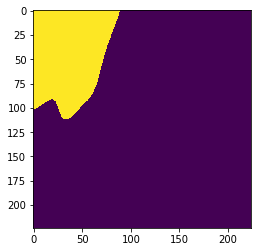

In [15]:
#Quick look on if the submission masks looks good.
plt.imshow(((preds[16]/kf*2)>0.5).astype(np.uint8))

In [16]:
p = [cv2.resize(o/kf*2,dsize=(101,101)) for o in preds]
p = [(o>0.5).astype(np.uint8) for o in p]

In [17]:
pred_dict = {id_[11:-4]:RLenc(p[i]) for i,id_ in tqdm_notebook(enumerate(tst_x))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('simple_k_fold_flipped.csv')